In [12]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entradam 784 neuronios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neuronios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neuronios que se ligam a 10
        # para a camada de saida não é necessario definir nada pois só preciso pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada pra camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para camada interna 2
        X = self.linear3(X) # função de ativação da camada interna 2 para camada de saída, neste caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

In [13]:
print(imagens[0].shape) # para mostrar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # para verificar o tamanho do tensor da etiqueta

torch.Size([1, 28, 28])
torch.Size([])


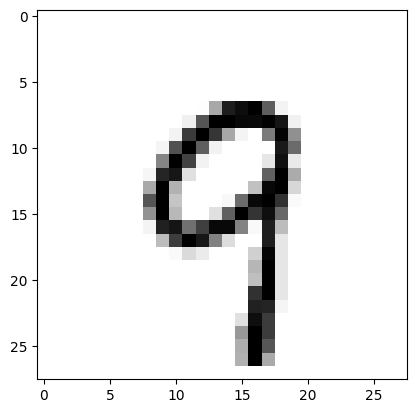

In [14]:
dataiter = iter(trainloader) #carraga da iteração do dataset
imagens, etiquetas = next(dataiter) #pega a próxima imagem e etiqueta do dataset
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r') #mostra a imagem

In [15]:
transform = transforms.ToTensor() # definindo a conversão  da imagem para tensor

trainset = datasets.MNIST('./MINST_data/', download=True, train=True, transform=transform)#Carraga a parte do treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)#Cria o buffer para pegar os dados do dataset

valset = datasets.MNIST('./MINST_data/', download=True, train=False, transform=transform)#Carrega a parte da validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)#Cria o buffer para pegar os dados do dataset

In [16]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
